# TITANIC

Nome: Rafel Seabra Ferrão e Ricardo Coutinho Cordeiro

Professor: Ulisses Brisolara Corrêa


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
# Carregar os dados de treino e teste
dados_treinamento = pd.read_csv('/content/drive/MyDrive/Titanic - Ferria/train.csv')
dados_teste = pd.read_csv('/content/drive/MyDrive/Titanic - Ferria/test.csv')

print(dados_treinamento.head())
print('-----------------------------------------------------------------------------------')
print(dados_teste.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
--

In [ ]:
# Pré-processamento dos dados
# Preencher valores ausentes em 'Age' com a mediana
dados_treinamento['Age'].fillna(dados_treinamento['Age'].median(), inplace=True)
dados_teste['Age'].fillna(dados_teste['Age'].median(), inplace=True)

# Preencher valores ausentes em 'Embarked' com a moda (valor mais frequente)
dados_treinamento['Embarked'].fillna(dados_treinamento['Embarked'].mode()[0], inplace=True)
dados_teste['Fare'].fillna(dados_teste['Fare'].median(), inplace=True)

# Remover a coluna 'Cabin'
dados_treinamento.drop(columns=['Cabin'], inplace=True)
dados_teste.drop(columns=['Cabin'], inplace=True)

In [ ]:
# Codificar variáveis categóricas
codificador = LabelEncoder()
dados_treinamento['Sex'] = codificador.fit_transform(dados_treinamento['Sex'])
dados_teste['Sex'] = codificador.transform(dados_teste['Sex'])

# Criar variáveis dummy para 'Embarked'
dados_treinamento = pd.get_dummies(dados_treinamento, columns=['Embarked'], drop_first=True)
dados_teste = pd.get_dummies(dados_teste, columns=['Embarked'], drop_first=True)

In [ ]:
# Engenharia de características
# Criar coluna 'FamilySize' com o tamanho da família
dados_treinamento['FamilySize'] = dados_treinamento['SibSp'] + dados_treinamento['Parch'] + 1
dados_teste['FamilySize'] = dados_teste['SibSp'] + dados_teste['Parch'] + 1

# Criar coluna 'IsAlone' para indicar se o passageiro está sozinho
dados_treinamento['IsAlone'] = 1
dados_treinamento.loc[dados_treinamento['FamilySize'] > 1, 'IsAlone'] = 0
dados_teste['IsAlone'] = 1
dados_teste.loc[dados_teste['FamilySize'] > 1, 'IsAlone'] = 0

       PassengerId    Survived      Pclass         Sex         Age  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.647587   29.361582   
std     257.353842    0.486592    0.836071    0.477990   13.019697   
min       1.000000    0.000000    1.000000    0.000000    0.420000   
25%     223.500000    0.000000    2.000000    0.000000   22.000000   
50%     446.000000    0.000000    3.000000    1.000000   28.000000   
75%     668.500000    1.000000    3.000000    1.000000   35.000000   
max     891.000000    1.000000    3.000000    1.000000   80.000000   

            SibSp       Parch        Fare  FamilySize     IsAlone  
count  891.000000  891.000000  891.000000  891.000000  891.000000  
mean     0.523008    0.381594   32.204208    1.904602    0.602694  
std      1.102743    0.806057   49.693429    1.613459    0.489615  
min      0.000000    0.000000    0.000000    1.000000    0.000000  
25%      0.000000    0.000000

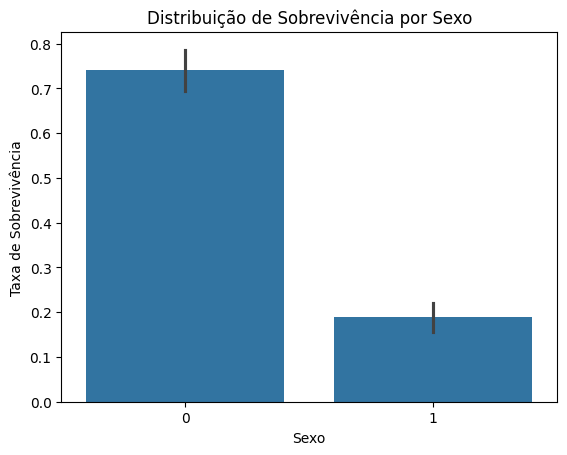

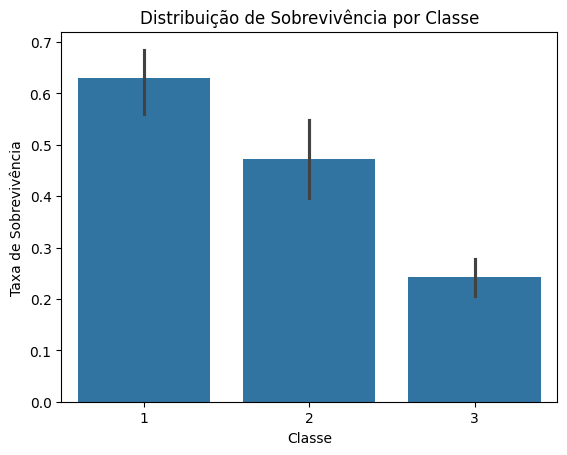

In [ ]:
# Exibir estatísticas descritivas dos dados
print(dados_treinamento.describe())

# Visualização: Distribuição de sobrevivência por sexo
sns.barplot(x='Sex', y='Survived', data=dados_treinamento)
plt.title('Distribuição de Sobrevivência por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Taxa de Sobrevivência')
plt.show()

# Visualização: Distribuição de sobrevivência por classe
sns.barplot(x='Pclass', y='Survived', data=dados_treinamento)
plt.title('Distribuição de Sobrevivência por Classe')
plt.xlabel('Classe')
plt.ylabel('Taxa de Sobrevivência')
plt.show()

In [ ]:
# Separar as variáveis preditoras e o alvo
X = dados_treinamento.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
y = dados_treinamento['Survived']

# Aplicar o SMOTE para balancear os dados
smote = SMOTE(random_state=42)
X_reamostrado, y_reamostrado = smote.fit_resample(X, y)

# Dividir os dados em treino e validação
X_treino, X_validacao, y_treino, y_validacao = train_test_split(X_reamostrado, y_reamostrado, test_size=0.2, random_state=42)

# Definir o grid de parâmetros para busca em grid
grade_parametros = {
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'criterion': ['gini', 'entropy']
}

# Buscar os melhores parâmetros usando validação cruzada
busca_grid = GridSearchCV(RandomForestClassifier(random_state=42), grade_parametros, cv=5, n_jobs=-1, verbose=1)
busca_grid.fit(X_treino, y_treino)

# Melhor modelo encontrado
melhor_modelo = busca_grid.best_estimator_
print(f"Melhores parâmetros: {busca_grid.best_params_}")

# Fazer previsões no conjunto de validação
y_predito = melhor_modelo.predict(X_validacao)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
120 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}


In [ ]:
# Desempenho do modelo
print(f"Acurácia: {accuracy_score(y_validacao, y_predito)}")
print(confusion_matrix(y_validacao, y_predito))
print(classification_report(y_validacao, y_predito))

Acurácia: 0.8909090909090909
[[ 95   8]
 [ 16 101]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       103
           1       0.93      0.86      0.89       117

    accuracy                           0.89       220
   macro avg       0.89      0.89      0.89       220
weighted avg       0.89      0.89      0.89       220



Número de passageiros que sobreviveram no conjunto de validação: 117

Importância das características:
  Característica  Importância
1            Sex     0.309346
5           Fare     0.225772
2            Age     0.200644
0         Pclass     0.102858
8     FamilySize     0.050311
3          SibSp     0.033149
4          Parch     0.026006
7     Embarked_S     0.019568
9        IsAlone     0.018336
6     Embarked_Q     0.014010


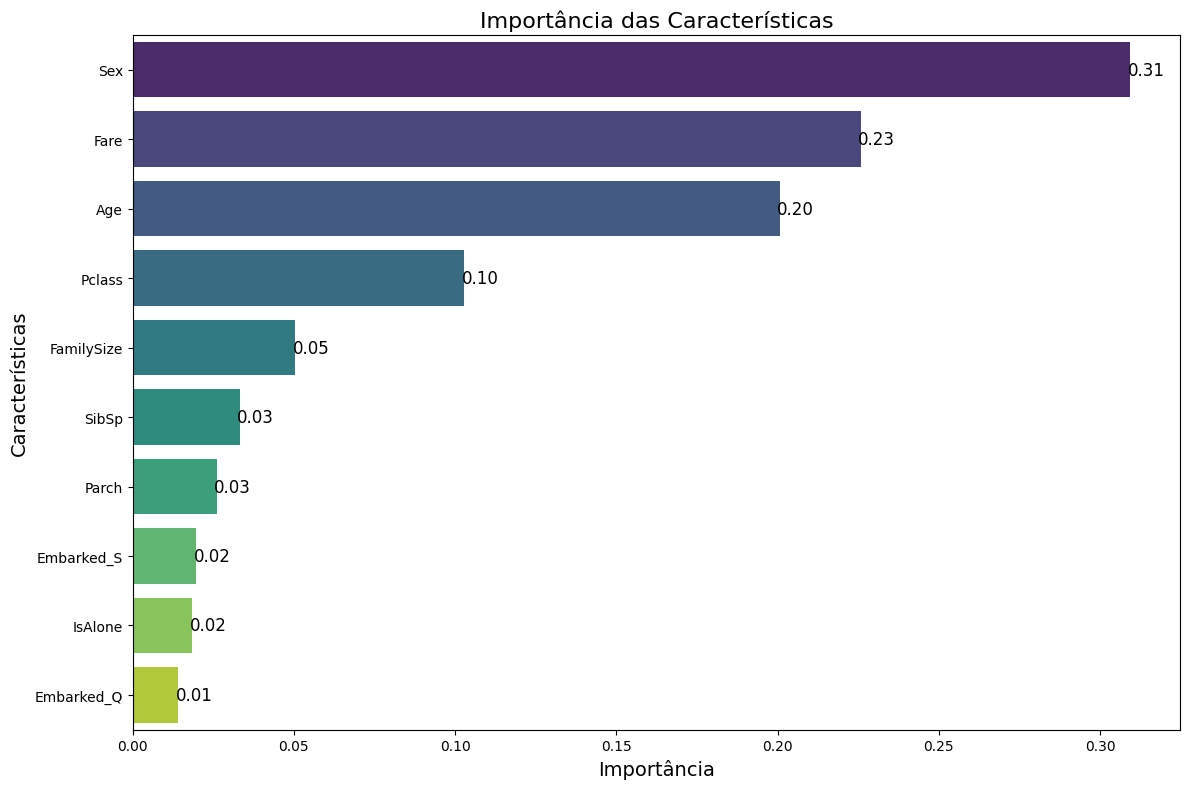

Número de passageiros que sobreviveram no conjunto de teste (estimado): 153


In [ ]:
# Contar o número de passageiros que sobreviveram no conjunto de validação
num_surviventes_validacao = sum(y_validacao)
print(f"Número de passageiros que sobreviveram no conjunto de validação: {num_surviventes_validacao}")

# Importância das características
importancias = melhor_modelo.feature_importances_
nomes_caracteristicas = X.columns
df_importancia_caracteristicas = pd.DataFrame({'Característica': nomes_caracteristicas, 'Importância': importancias})
df_importancia_caracteristicas = df_importancia_caracteristicas.sort_values(by='Importância', ascending=False)
print("\nImportância das características:")
print(df_importancia_caracteristicas)

# Visualização: Importância das características
plt.figure(figsize=(12, 8))

ax = sns.barplot(x='Importância', y='Característica', hue='Característica', data=df_importancia_caracteristicas, palette='viridis', dodge=False, legend=False)

plt.title('Importância das Características', fontsize=16)
plt.xlabel('Importância', fontsize=14)
plt.ylabel('Características', fontsize=14)

# Adicionar valores nas barras
for p in ax.patches:
    largura = p.get_width()
    plt.text(largura + 0.005, p.get_y() + p.get_height() / 2, f'{largura:.2f}', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# Faz previsões no conjunto de teste
X_teste = dados_teste.drop(columns=['Name', 'Ticket', 'PassengerId'])
previsoes_teste = melhor_modelo.predict(X_teste)

# Conta o número de passageiros que sobreviveram no conjunto de teste (estimado)
num_surviventes_teste = sum(previsoes_teste)
print(f"Número de passageiros que sobreviveram no conjunto de teste (estimado): {num_surviventes_teste}")

# Prepara o arquivo de submissão
submissao = pd.DataFrame({
    "PassengerId": dados_teste['PassengerId'],
    "Survived": previsoes_teste
})
submissao.to_csv('submission.csv', index=False)

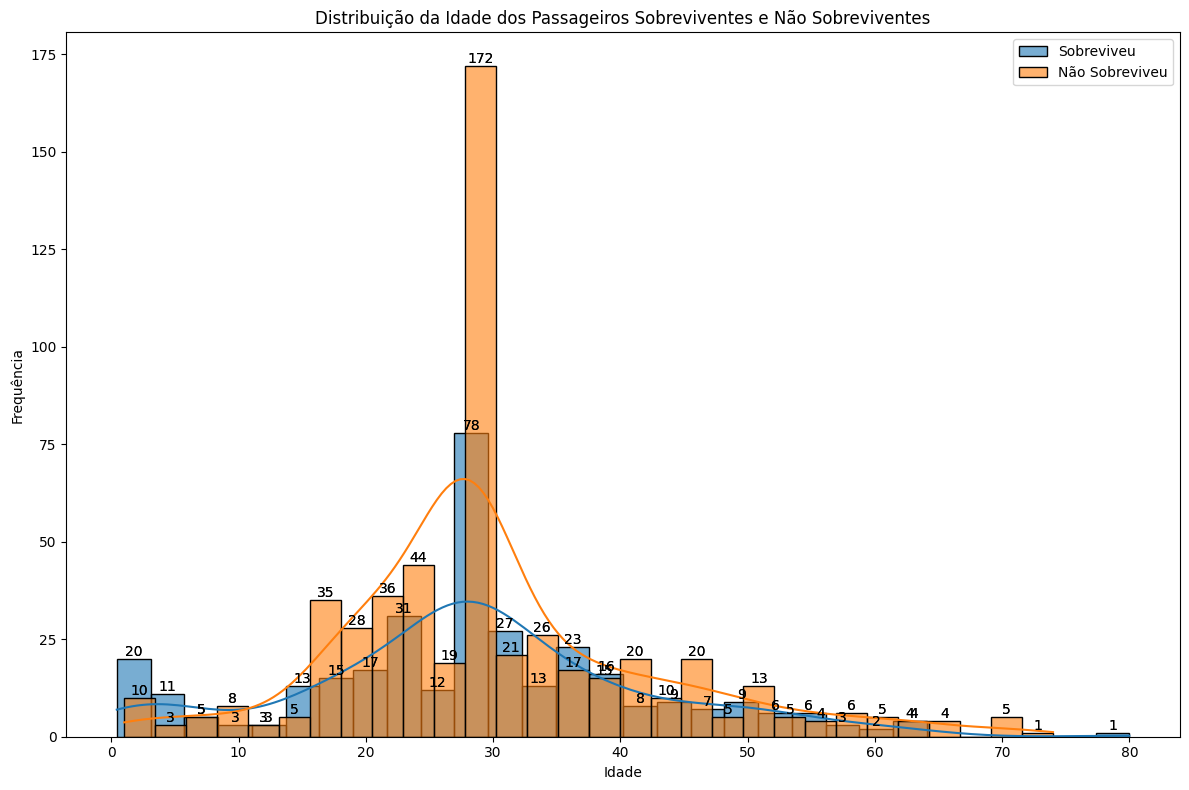

In [ ]:
# Visualização: Distribuição da idade dos passageiros sobreviventes e não sobreviventes
plt.figure(figsize=(12, 8))

cor_survive = '#1f77b4'
cor_not_survive = '#ff7f0e'

hist_survive = sns.histplot(data=dados_treinamento[dados_treinamento['Survived'] == 1], x='Age', bins=30, kde=True, color=cor_survive, label='Sobreviveu', alpha=0.6)
hist_not_survive = sns.histplot(data=dados_treinamento[dados_treinamento['Survived'] == 0], x='Age', bins=30, kde=True, color=cor_not_survive, label='Não Sobreviveu', alpha=0.6)

plt.title('Distribuição da Idade dos Passageiros Sobreviventes e Não Sobreviventes')
plt.xlabel('Idade')
plt.ylabel('Frequência')

plt.legend()

# Adicionar valores nas barras
for p in hist_survive.patches:
    altura = p.get_height()
    if altura > 0:
        plt.text(p.get_x() + p.get_width() / 2, altura, f'{int(altura)}', ha='center', va='bottom', color='black', fontsize=10)

for p in hist_not_survive.patches:
    altura = p.get_height()
    if altura > 0:
        plt.text(p.get_x() + p.get_width() / 2, altura, f'{int(altura)}', ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()

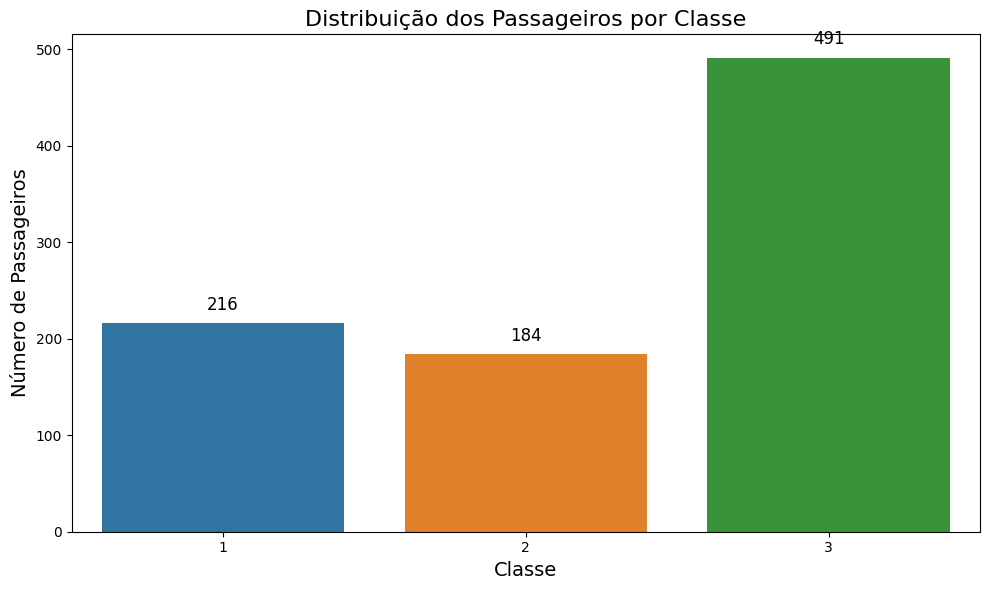

In [ ]:
# Visualização: Distribuição dos passageiros por classe
plt.figure(figsize=(10, 6))

ax = sns.countplot(x='Pclass', hue='Pclass', data=dados_treinamento, palette=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)

plt.title('Distribuição dos Passageiros por Classe', fontsize=16)
plt.xlabel('Classe', fontsize=14)
plt.ylabel('Número de Passageiros', fontsize=14)

# Adicionar valores nas barras
for p in ax.patches:
    altura = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2, altura + 10, f'{int(altura)}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

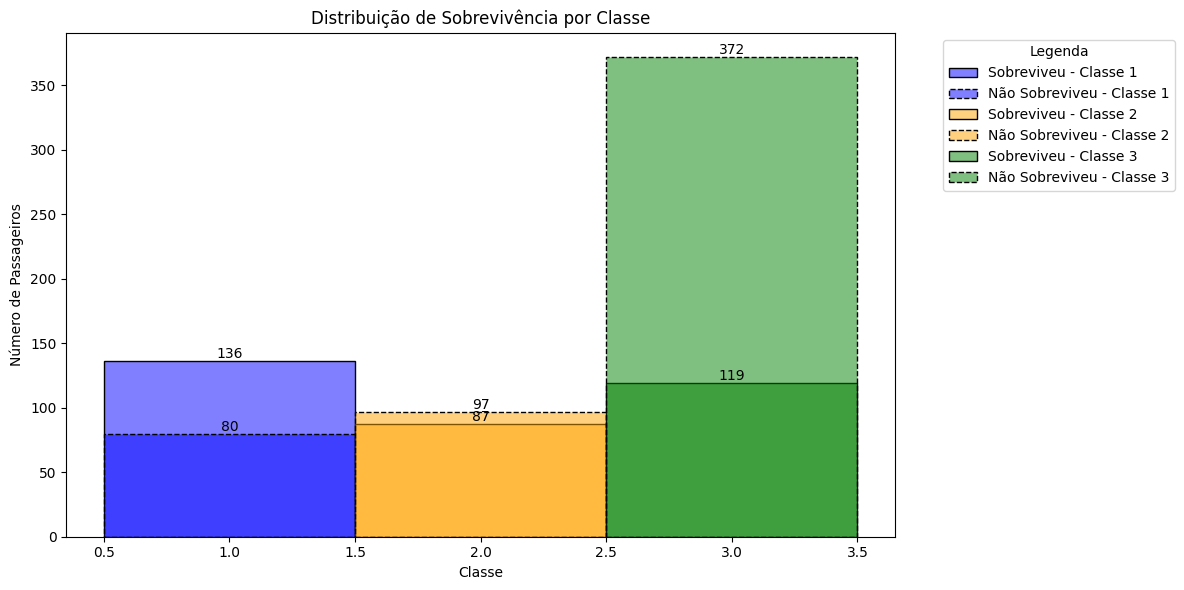

In [ ]:
plt.figure(figsize=(12, 6))

# Definir as classes e cores
classes = sorted(dados_treinamento['Pclass'].unique())
cores = ['blue', 'orange', 'green']
rotulos = [f'Classe {cls}' for cls in classes]

# Plotar a distribuição de sobrevivência por classe
for cls, cor in zip(classes, cores):
    sns.histplot(data=dados_treinamento[(dados_treinamento['Survived'] == 1) & (dados_treinamento['Pclass'] == cls)],
                 x='Pclass', discrete=True, color=cor, label=f'Sobreviveu - {rotulos[cls-1]}', kde=False, alpha=0.5)

    sns.histplot(data=dados_treinamento[(dados_treinamento['Survived'] == 0) & (dados_treinamento['Pclass'] == cls)],
                 x='Pclass', discrete=True, color=cor, label=f'Não Sobreviveu - {rotulos[cls-1]}', kde=False, alpha=0.5, linestyle='--')

plt.title('Distribuição de Sobrevivência por Classe')
plt.xlabel('Classe')
plt.ylabel('Número de Passageiros')

plt.legend(title='Legenda', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adicionar valores numéricos às barras
for p in plt.gca().patches:
    altura = p.get_height()
    if altura > 0:
        plt.text(p.get_x() + p.get_width() / 2., altura, f'{int(altura)}', ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()
plt.show()

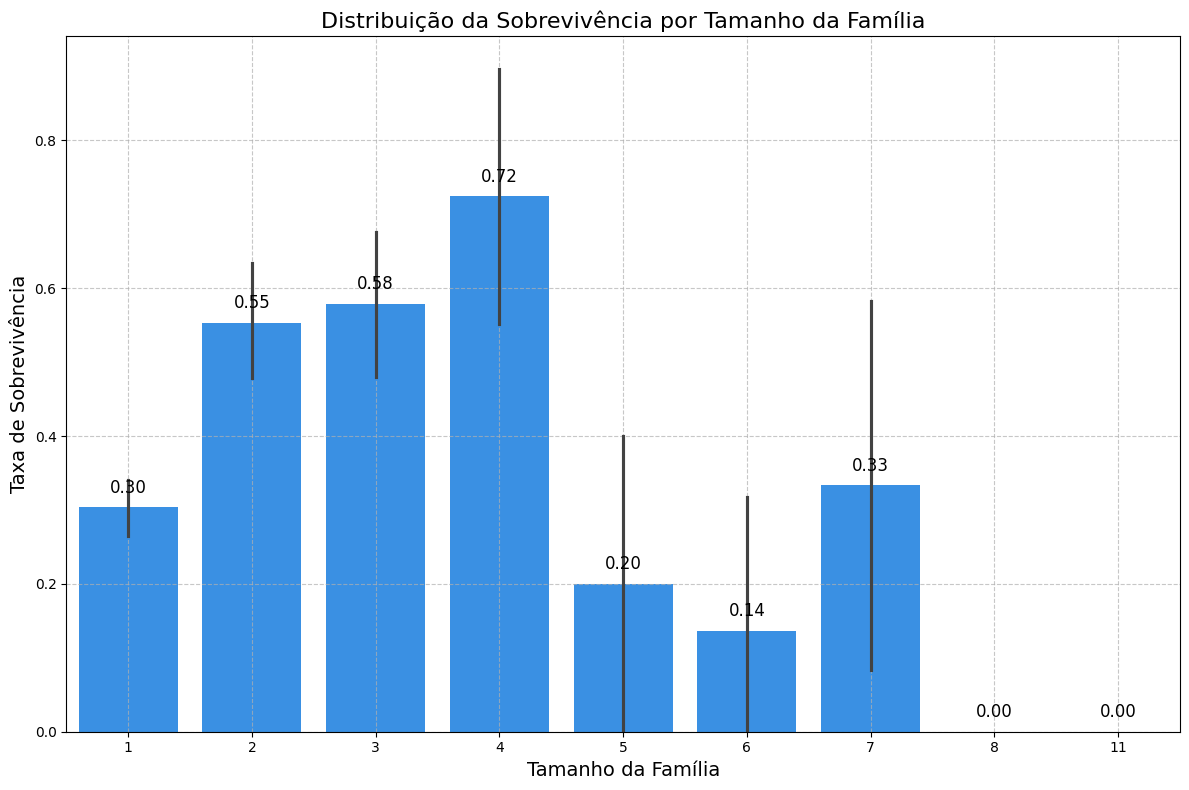

In [ ]:
plt.figure(figsize=(12, 8))

# Criar o gráfico de barras para a taxa de sobrevivência por tamanho da família
sns.barplot(x='FamilySize', y='Survived', data=dados_treinamento, color='dodgerblue')
plt.title('Distribuição da Sobrevivência por Tamanho da Família', fontsize=16)
plt.xlabel('Tamanho da Família', fontsize=14)
plt.ylabel('Taxa de Sobrevivência', fontsize=14)

# Adicionar valores numéricos acima das barras
for i in range(len(dados_treinamento['FamilySize'].unique())):
    plt.text(i,
             dados_treinamento.groupby('FamilySize')['Survived'].mean().values[i] + 0.02,
             f"{dados_treinamento.groupby('FamilySize')['Survived'].mean().values[i]:.2f}",
             ha='center', fontsize=12, color='black')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

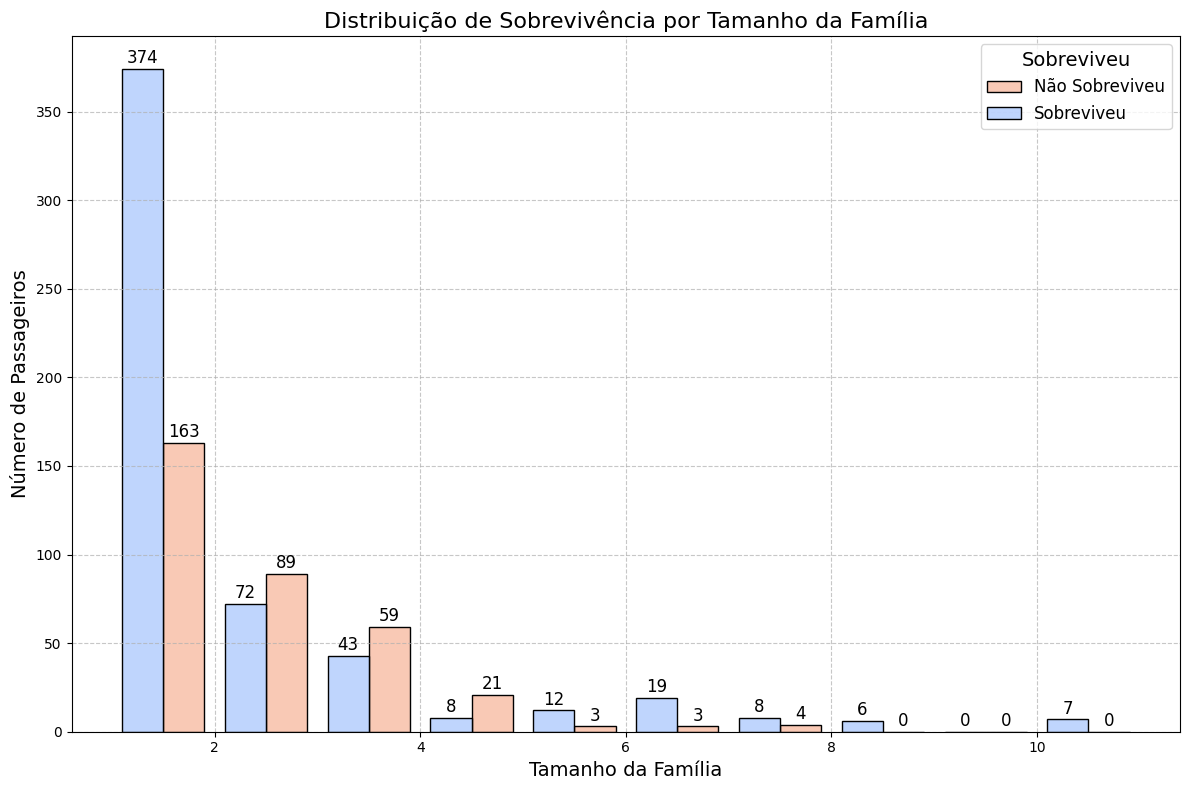

In [ ]:
plt.figure(figsize=(12, 8))

# Definir a paleta de cores para o gráfico
cores = sns.color_palette("coolwarm", 2)

# Criar o histograma para a distribuição de sobrevivência por tamanho da família
hist_plot = sns.histplot(data=dados_treinamento, x='FamilySize', hue='Survived', multiple='dodge',
                         palette=cores, kde=False, binwidth=1, shrink=0.8)

# Adicionar valores numéricos acima das barras
for p in hist_plot.patches:
    altura = p.get_height()
    largura = p.get_width()
    x = p.get_x() + largura / 2
    y = altura + 1
    hist_plot.annotate(f'{int(altura)}', (x, y), ha='center', va='bottom', fontsize=12, color='black')

plt.title('Distribuição de Sobrevivência por Tamanho da Família', fontsize=16)
plt.xlabel('Tamanho da Família', fontsize=14)
plt.ylabel('Número de Passageiros', fontsize=14)
plt.legend(title='Sobreviveu', labels=['Não Sobreviveu', 'Sobreviveu'], fontsize=12, title_fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

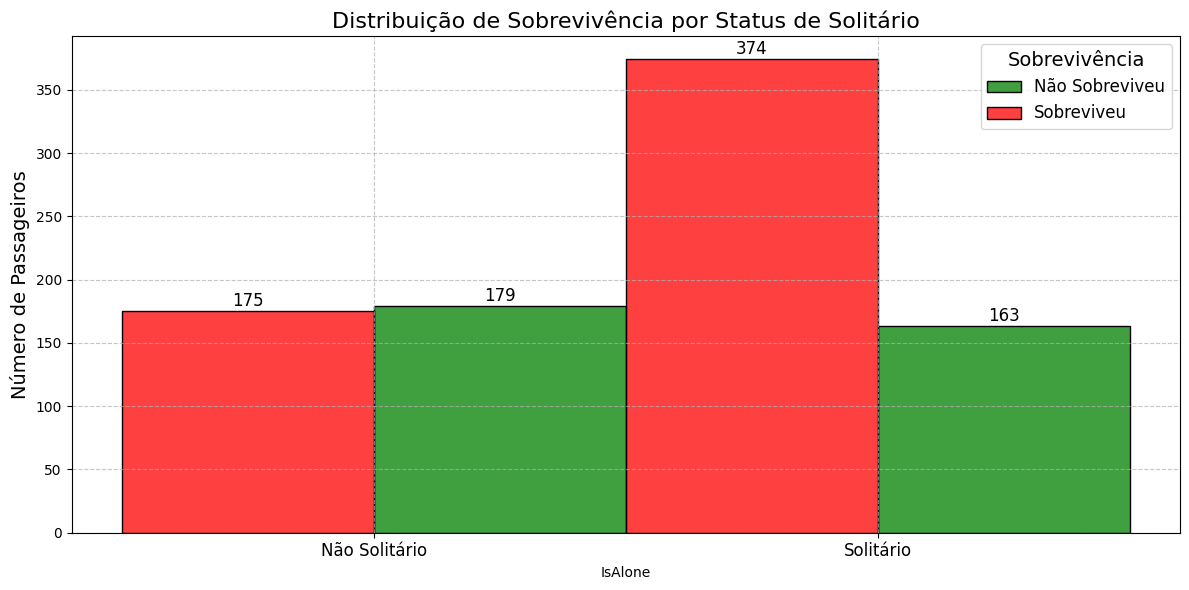

In [ ]:
plt.figure(figsize=(12, 6))

# Criar o histograma para a distribuição de sobrevivência por status de solitário
hist_plot = sns.histplot(data=dados_treinamento, x='IsAlone', hue='Survived', multiple='dodge',
                         palette={0: 'red', 1: 'green'}, discrete=True, kde=False, binwidth=1)

# Adicionar valores numéricos acima das barras
for p in hist_plot.patches:
    altura = p.get_height()
    largura = p.get_width()
    x = p.get_x() + largura / 2
    y = altura + 1
    hist_plot.annotate(f'{int(altura)}', (x, y), ha='center', va='bottom', fontsize=12, color='black')

plt.legend(title='Sobrevivência', title_fontsize=14, fontsize=12, labels=['Não Sobreviveu', 'Sobreviveu'])
plt.xticks(ticks=[0, 1], labels=['Não Solitário', 'Solitário'], fontsize=12)
plt.title('Distribuição de Sobrevivência por Status de Solitário', fontsize=16)
plt.ylabel('Número de Passageiros', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

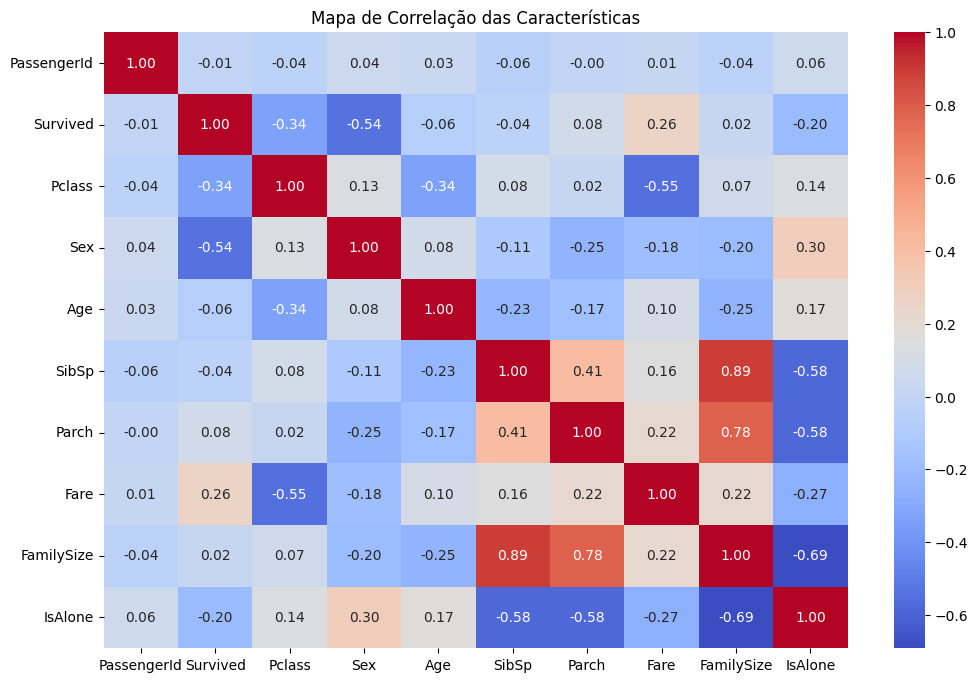

In [ ]:
# Seleciona apenas as colunas numéricas do DataFrame de treino
df_numerico = dados_treinamento.select_dtypes(include=[np.number])

# Calcula a matriz de correlação entre as variáveis numéricas
correlacao = df_numerico.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlação das Características')
plt.show()

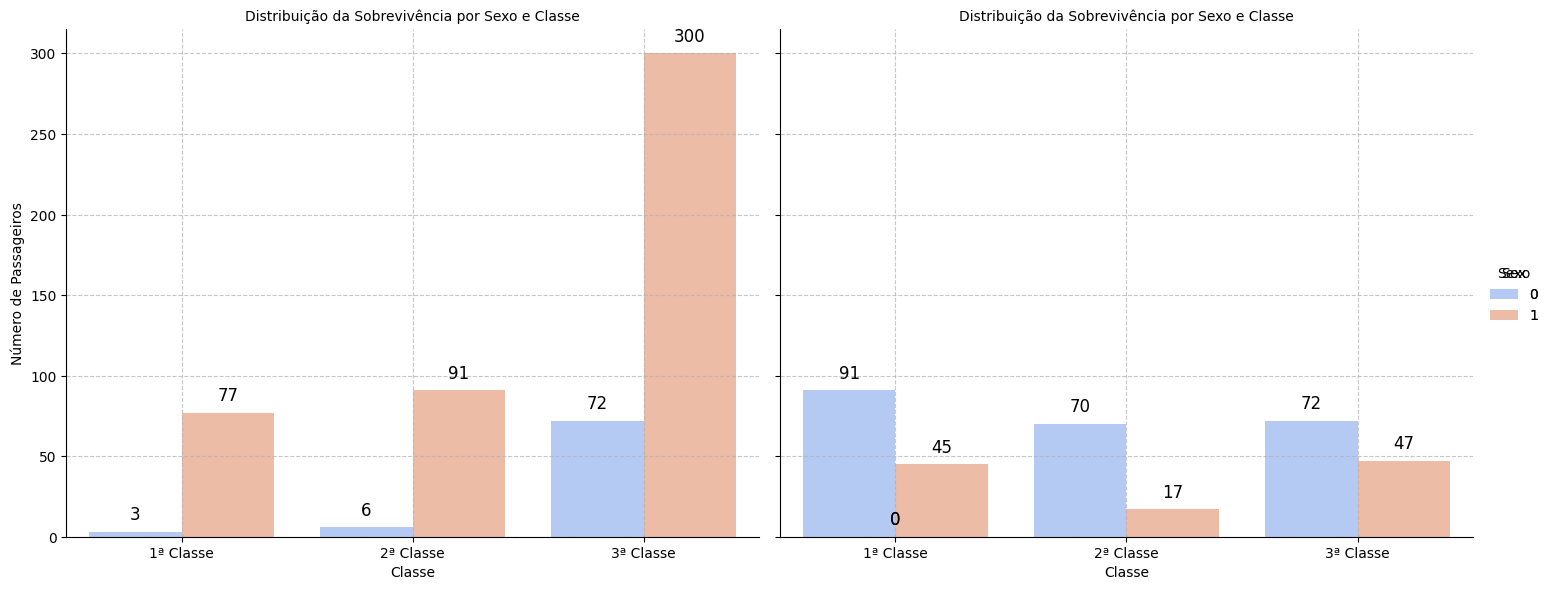

In [ ]:
# Cria um gráfico de contagem com múltiplos subgráficos, dividido por sobrevivência, classe e sexo
g = sns.catplot(x='Pclass', hue='Sex', col='Survived', kind='count', data=dados_treinamento, height=6, aspect=1.2, palette='coolwarm')

# Adiciona anotações com a contagem de passageiros em cada barra
for ax in g.axes.flat:
    for p in ax.patches:
        altura = p.get_height()
        x = p.get_x() + p.get_width() / 2
        y = altura + 5
        ax.annotate(f'{int(altura)}', (x, y), ha='center', va='bottom', fontsize=12, color='black')

g.set_titles('Distribuição da Sobrevivência por Sexo e Classe')
g.set_axis_labels('Classe', 'Número de Passageiros')
g.set_xticklabels(['1ª Classe', '2ª Classe', '3ª Classe'])
g.add_legend(title='Sexo')

# Adiciona uma grade aos subgráficos
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

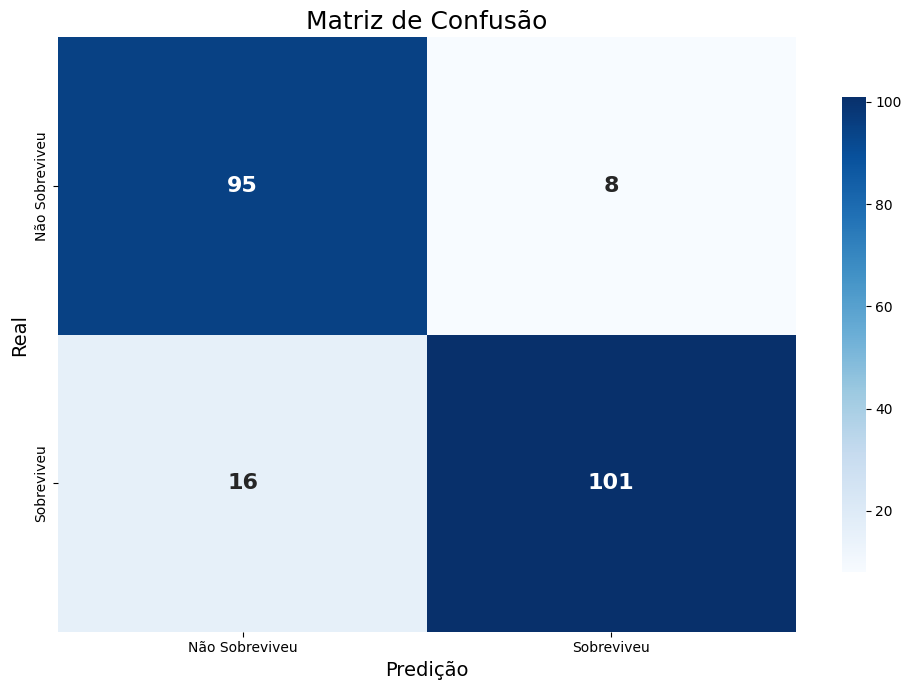

In [ ]:
# Calcula a matriz de confusão com base nos rótulos verdadeiros e previstos
cm = confusion_matrix(y_val, y_pred)

# Cria uma figura para a matriz de confusão
plt.figure(figsize=(10, 7))

# Plota a matriz de confusão usando um mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'],
            annot_kws={'size': 16, 'weight': 'bold'},
            cbar_kws={'shrink': .8})

plt.title('Matriz de Confusão', fontsize=18)
plt.xlabel('Predição', fontsize=14)
plt.ylabel('Real', fontsize=14)
plt.tight_layout()
plt.show()